**Lab 02: A little bit lower API**

Trong bài thực hành này chúng ta sẽ thực hành tự thiết kê các layers thông qua việc tự định nghĩa kernel, activation. Định nghĩa một block

In [ ]:
#import thư viện cần thiết
## thư viện machine learning và hỗ trợ
import tensorflow as tf
from tensorflow import keras
import numpy as np

## thư viện để vẽ đồ thị
import matplotlib.pyplot as plt

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test
Mỗi ảnh có một kênh màu, kích thước 28x28

Ảnh đầu tiên của tập train
Label đầu tiên của tập train:  5


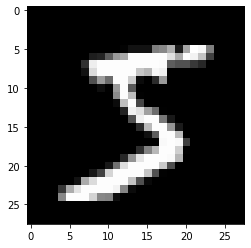

In [ ]:
# Tải dataset MNIST từ tensorflow
## MNIST là bài toán dự đoán một ảnh thể hiện ký tự số nào

## tải MNIST dataset từ keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

##in dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test")
print("Mỗi ảnh có một kênh màu, kích thước 28x28")
print()

## in thử ảnh một ảnh
print("Ảnh đầu tiên của tập train")
print("Label đầu tiên của tập train: ", y_train[0])
plt.imshow(X_train[0], cmap='gray')
plt.show()

#Tách một phần tập train thành tập valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

#Layer



Chúng ta sẽ tiến hành viết code đè lên các layer đã được định nghĩa trên keras.layers.Layer

**__init__**: khởi tạo, lưu tham số cho layer

**build**: thiết lập layer dựa vào shape của input, khai báo các biến, các layer ở hàm này

**call**: cài đặt những tính toán feedforward



In [ ]:
from keras import backend as K
from keras.models import Model
import tensorflow as tf
from keras.layers import Input, Layer

class FullyConnectedLayer(Layer):
    def __init__(self, n_units=10, activation=tf.nn.sigmoid):
        print("__init__ called")
        ## n_units, activation là tham số do mình tự định nghĩa
        ## n_units thể hiện số nơ-ron của lớp fully connected
        ## activation là hàm kích hoạt
        
        # gọi hàm khởi tạo của lớp cha
        super(FullyConnectedLayer, self).__init__()
        # lưu lại số nơ-ron của lớp này
        self.n_units = n_units
        self.activation_function = activation

    def build(self, input_shape):
        print("build called")
        ## input_shape: là shape của input của layer này
        ## tham số này là bắt buộc
        
        ### Tạo biến có kích thước [input_shape[-1], self.n_units],
        ### các giá trị biến tạo ngẫu nhiên theo phân phối chuẩn mean = 0, std = 0.01
        
        self.kernel = self.add_variable(name='kernel',
                                        shape=[int(input_shape[-1]), self.n_units], 
                                        initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.01))
        
        ## Tương tự, khai báo một vector bias
        self.bias = self.add_variable(name='bias',
                                      shape=[self.n_units],
                                      initializer=keras.initializers.Ones())

        
    def call(self, inputs):
        print("call called")

        ## input chính là một lớp keras (hoặc tensor) truyền vào layer này
        ## tham số input là bắt buộc
        
        ## Công thức toán học của lớp này
        ## tensorflow có hỗ broadcasting nên self.bias sẽ được cộng vào từng dòng của ma trận
        matmul = tf.matmul(inputs, self.kernel) + self.bias
        outputs = self.activation_function(matmul)  ##áp dụng hàm kích hoạt
        return outputs

## Thử xem những tham số và kích thước của layer với input là vector (300,)
inputs = keras.layers.Input(shape=(300,))
conv = FullyConnectedLayer(n_units=10)      ## hàm __init__ được gọi
conv_output = conv(inputs)                  ## hàm build và call được gọi

## In các biến train được của layer
## conv.trainable_variables trả về một list các biến train được của layer
print(conv.trainable_variables)
## In output của layer
print(conv_output.shape)


__init__ called
build called
call called
[<tf.Variable 'fully_connected_layer_1/kernel:0' shape=(300, 10) dtype=float32, numpy=
array([[ 0.00632867, -0.01016562, -0.00443575, ..., -0.00321748,
         0.00531245,  0.01858934],
       [-0.00738242,  0.00814261, -0.0161181 , ...,  0.01690721,
        -0.00535877, -0.00396557],
       [-0.00732769, -0.00164712, -0.00798128, ..., -0.01121267,
         0.02553568, -0.0035396 ],
       ...,
       [ 0.00070453, -0.00047802,  0.00617089, ...,  0.0136091 ,
        -0.00605257, -0.00107126],
       [-0.00262193,  0.00439475,  0.00372333, ..., -0.01044396,
         0.00646729, -0.01062681],
       [-0.00582822,  0.00050675,  0.00136826, ..., -0.00280495,
        -0.0056946 ,  0.00465482]], dtype=float32)>, <tf.Variable 'fully_connected_layer_1/bias:0' shape=(10,) dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>]
(None, 10)


In [ ]:
class ConvMaxpoolBlock(keras.layers.Layer):
    ## Lớp này sẽ xây dựng lớp convolutional layer và maxpooling
    
    
    def __init__(self, filter_size, n_filters):
        ## filter_size sẽ dùng như là kích thước của filter của lớp convolution
        ## là một list 2 phần tử
        ## n_filters là số filter của lớp convolution
        ## là một số nguyên
        
        # gọi hàm khởi tạo của lớp cha
        super(ConvMaxpoolBlock, self).__init__()
        # lưu lại mấy thông số
        self.filter_size = filter_size
        self.n_filters = n_filters
        
    def build(self, input_shape):
        ## ta giả sử input là một tensor (layer) có kích thước [None, height, weight, n_channels]
        
        ## khởi tạo và khai báo kernel
        self.kernel = self.add_variable(name='kernel',
                                        shape=[self.filter_size[0], self.filter_size[1], int(input_shape[-1]), self.n_filters],
                                        initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05))
        
        ## khởi tạo và khai báo bias
        self.bias = self.add_variable(name='bias',
                                      shape=[self.n_filters],
                                        initializer=keras.initializers.Ones())
        
    def call(self, inputs):
        ## phép toán tích chập
        conv = K.conv2d(x=inputs,
                            kernel=self.kernel,
                       padding='same')
        ## cộng bias (có broadcasting hỗ trợ nên lập trình đơn giản)
        conv = conv + self.bias
        ## áp dụng hàm kích hoạt
        conv = tf.nn.relu(conv)
        ## áp dụng maxpooling
        maxpool = K.pool2d(conv, 
                           pool_size=(2,2), 
                           strides=(2,2),
                          pool_mode='max')
                          
        return maxpool

## Thử xem những tham số và kích thước của layer với input là ảnh (300,300,3)
inputs = keras.layers.Input(shape=(300,300,3))
conv = ConvMaxpoolBlock(filter_size=[5,5], n_filters=10)  ##hàm __init__ được gọi
conv_output = conv(inputs)                                ##hàm build và call được gọi

## In các biến train được của layer
print(conv.trainable_variables)
## In output của layer
print(conv_output.shape)

[<tf.Variable 'conv_maxpool_block_14/kernel:0' shape=(5, 5, 3, 10) dtype=float32, numpy=
array([[[[-9.46072862e-04,  4.98239063e-02,  4.38046642e-02,
          -1.79500133e-02,  3.91131081e-02,  1.41602876e-02,
           2.38595195e-02, -6.93457201e-02,  1.09681310e-02,
          -2.43144445e-02],
         [-7.17320144e-02, -5.68615757e-02, -5.09358719e-02,
          -4.82687056e-02, -6.45734221e-02,  2.19901949e-02,
          -4.22048308e-02,  1.49264768e-01, -6.64966181e-02,
          -5.76939099e-02],
         [-8.59334692e-03, -1.54117262e-02,  1.68138128e-02,
           2.34135203e-02, -4.70389687e-02, -3.47604230e-02,
          -2.06825305e-02, -2.66614053e-02,  1.22819237e-01,
          -1.69241487e-03]],

        [[-2.47595515e-02,  2.45232750e-02, -5.92702627e-02,
           1.77050084e-02,  9.05365050e-02,  4.60688621e-02,
           1.37902185e-01,  2.96686534e-02, -2.70531187e-03,
           2.20485367e-02],
         [ 2.65245680e-02,  1.80577897e-02,  1.73662510e-02,
    

#Bài tập

1. Hãy tạo một class DoubleFullyConnectedLayer với hàm activation lớp fully connected đầu là relu và lớp fully connected tiếp theo là softmax

2. Hãy huấn luyện một neural-network theo cấu trúc saug:

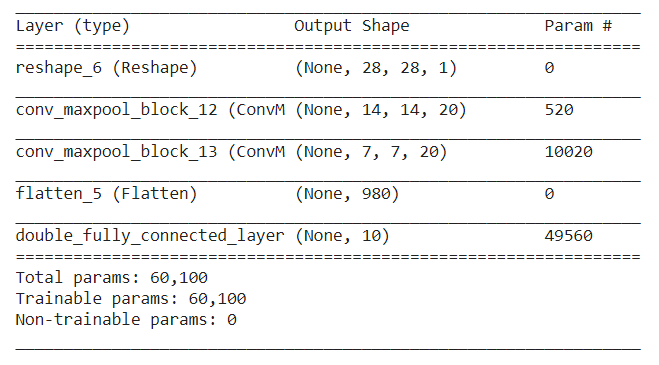

3.Sau khi huấn luyện hãy vẽ biểu đồ accuracy từng epoch trên tập training và tập validation. Có thể vẽ như hình sau:

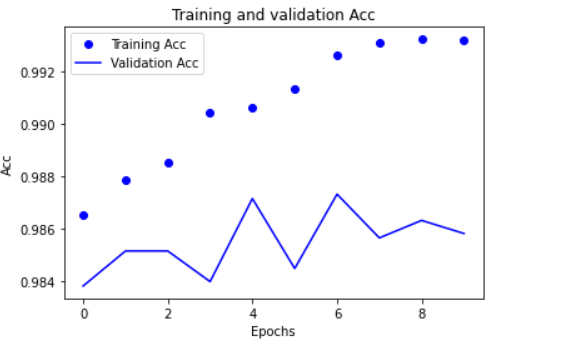